## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important to get some practice working with the difficulties of these tests.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# We are setting the seed to assure you get the same answers
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [18]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
len(df)

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
len(df.query('converted == 1')) / len(df)

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df['group'].unique()

array(['control', 'treatment'], dtype=object)

In [7]:
df['landing_page'].unique()

array(['old_page', 'new_page'], dtype=object)

In [8]:
df.query('group != "treatment" and landing_page == "new_page"').count() + df.query('group == "treatment" and landing_page != "new_page"').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [10]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [19]:
df2 = df.drop(df.query('group != "treatment" and landing_page == "new_page"').index)
df2 = df2.drop(df2.query('group == "treatment" and landing_page != "new_page"').index)

In [20]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [15]:
df[df['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [16]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [21]:
df2.drop(df2[df2.user_id.duplicated()].index,inplace=True)

In [22]:
df2[df2.user_id.duplicated()].sum().sum()

0.0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
df2[df2.converted == 1].shape[0] / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
df2.query('group == "control" and converted == 1').shape[0] / df2.query('group == "control"').shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
df2.query('group == "treatment" and converted == 1').shape[0] / df2.query('group == "treatment"').shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [22]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**I can't tell from just these probabilities that there is sufficient evidence to support one of the pages but this conclusion could be achieved after conducting hypothesis testing or using the confidence interval**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**H0 : $p_{new}$ <= $p_{old}$**

**HA : $p_{new}$ > $p_{old}$** 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [23]:
new_cr = df2.query('group == "treatment" and converted == 1').shape[0] / df2.query('group == "treatment"').shape[0]
new_cr

0.11880806551510564

b. What is the **conversion rate** for $p_{old}$ under the null? <br>

In [24]:
old_cr = df2.query('group == "control" and converted == 1').shape[0] / df2.query('group == "control"').shape[0]
old_cr

0.1203863045004612

c. What is $n_{new}$, the number of individuals in the treatment group?

In [25]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [26]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = np.random.choice([0,1],n_new,p=[1-new_cr,new_cr])
new_page_converted.mean()

0.11963388617438579

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.choice([0,1],n_old,p=[1-old_cr,old_cr])
old_page_converted.mean()

0.11887192477662899

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.00076196139775680516

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [30]:
p_diffs = []
for _ in range(10000):
    bootstrap_new = np.random.choice([0,1],n_new,replace=True,p=[1-new_cr,new_cr])
    bootstrap_old = np.random.choice([0,1],n_old,replace=True,p=[1-old_cr,old_cr])
    p_diffs.append(bootstrap_new.mean() - bootstrap_old.mean())
# convert p_diffs to numpy array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

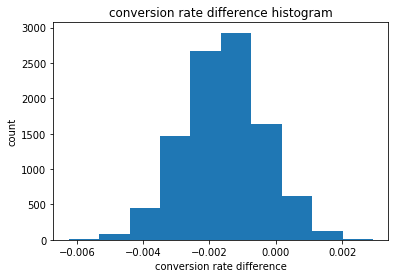

In [31]:
plt.hist(p_diffs)
plt.xlabel('conversion rate difference')
plt.ylabel('count')
plt.title('conversion rate difference histogram');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
statistic = new_cr - old_cr
statistic

-0.0015782389853555567

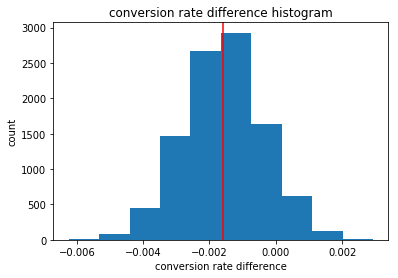

In [33]:
plt.hist(p_diffs)
plt.xlabel('conversion rate difference')
plt.ylabel('count')
plt.axvline(statistic,color='red')
plt.title('conversion rate difference histogram');

In [34]:
p_val = (p_diffs > statistic).mean()
p_val

0.50429999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**This value is called p-value and it's the probability of obtaining test results at least as extreme as the results observed, under the assumption that the null hypothesis is correct. And with significance level equal to 5% and p-value > significance level, we could say that we couldn't reject the null hypothesis which means with significance level equal to 5%, we couldn't find sufficient evidence to support that new page has conversion rate greater than the old page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [23]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1').shape[0] / df2.query('group == "control"').shape[0]
convert_new = df2.query('group == "treatment" and converted == 1').shape[0] / df2.query('group == "treatment"').shape[0]
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [36]:
zstat,p_value = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old],alternative='larger')
display(zstat)
display(p_value)

-0.0032875796753531767

0.50131155217010437

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**With significance level equal to 5% and p-value > significance level, we could say that we couldn't reject the null hypothesis which means with significance level equal to 5%, we couldn't find sufficient evidence to support that new page has conversion rate greater than the old page**

**And YES the z-test result is similar to what we got using the bootstrapping approach**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [24]:
# add intercept to dataframe
df2['intercept'] = 1
df2['ab_page'] = df2.group.apply(lambda x:1 if x=="treatment" else 0)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [25]:
model = sm.Logit(df2.converted,df2[['intercept','ab_page']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [26]:
# fix error "AttributeError: module 'scipy.stats' has no attribute 'chisqprob'"
# for more information visit https://github.com/statsmodels/statsmodels/issues/3931
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# show summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 17 Sep 2020   Pseudo R-squ.:               8.077e-06
Time:                        01:04:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with ab_page equal to 0.190 and it differ because the hypothesis are different**

The main null hypothesis of a multiple logistic regression is that there is no relationship between the X variables and the Y variable

in other words: 

**H0 : coefficient for each variable in X = 0**

**HA : coefficient for each variable in X != 0**

but in Part II the hypothesis was

**H0 : $p_{new}$ <= $p_{old}$**

**HA : $p_{new}$ > $p_{old}$** 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding new features or variables to the model is a good thing as long as it extends the model exploratory capabilities, metrics like Pseudo-R-squared and Log-Likelihood Ratio can help us in the diagnostics of a given logistic regression model**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [27]:
# read in countries file
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [28]:
# add country variable to the dataframe by appling inner join operation between the two dataframes
df2 = df2.join(countries.set_index('user_id'),on='user_id',how='inner')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [29]:
# check the result of join operation
df2[df2['user_id'] == 711597]

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
48778,711597,2017-01-22 03:14:24.763511,control,old_page,0,1,0,UK


In [43]:
# show the catagories of the country feature
df2.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [30]:
# create dummy variables for the country feature
df2[['CA','UK','US']] = pd.get_dummies(df2['country'])

In [45]:
# create another logistic regression model 
# use UK as a baseline or as a reference for countries varibles
model2 = sm.Logit(df2.converted,df2[['intercept','ab_page','US', 'CA']])
result2 = model2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 17 Sep 2020   Pseudo R-squ.:               2.323e-05
Time:                        00:42:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [31]:
# add interaction between page and country
df2['ab_page_US'] = df2['ab_page'] * df2['US']
df2['ab_page_CA'] = df2['ab_page'] * df2['CA']

In [47]:
# create the third logistic regression model 
# use UK as a baseline or as a reference for countries varibles
model3 = sm.Logit(df2.converted,df2[['intercept','ab_page','US', 'CA','ab_page_US','ab_page_CA']])
result3 = model3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 17 Sep 2020   Pseudo R-squ.:               3.482e-05
Time:                        00:42:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
US             0.0057      0.019      0.306      0.760      -0.031       0.043
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
ab_page_US    -0.0314      0.027     -1.181      0.238      -0.084       0.021
ab_page_CA    -0.0783      0.057     -1.378      0.168      -0.190       0.033
==============================================================================
"""

In [42]:
# how much time this AB test lasted ?
time = pd.to_datetime(df2.timestamp).sort_values()
time.iloc[-1] - time.iloc[0]

Timedelta('21 days 23:59:49.081927')

<a id='conclusions'></a>
## Conclusions
After adding interaction variables to the model, I observed that p-values for all interaction variables are greater than 0.05 which means that we couldn't reject the null hypothesis and with this, I couldn't find sufficient evidence to support that there is a relationship between country of the individual and the page they landed to predict if they converted or not.

Also from the previous part of the analysis, I couldn't find sufficient evidence to support that the new page makes a higher conversion rate than the old page, and given that this test run for more than 21 days, I suggest to not launch the new page unless this new page provides a practical significance

In [51]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0